# vCAT MODEL GLM1


#### Create ROI masks

#### Transform caudate mask to EPI space

#### Move shit

# ROI mask specs:
### Hippocampus (FS labels: hippocampus [17, 53])
### Putamen (FS labels: putamen [12, 51])
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsal caudate (hand-drawn)

In [1]:
from os.path import join
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

subs = ['sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-010', 
        'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 
        'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 
        'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 
        'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032']
proj_dir = '/home/data/madlab/Mattfeld_vCAT' 
masks = []
copes = []
for sub in subs:
    masks_glob = glob(join(proj_dir, 'derivatives/roi_masks', sub, 'bi-*.nii.gz'))
    masks.append(sorted(masks_glob))
    copes_glob = glob(join(proj_dir, 'derivatives/GLM1/lvl2', sub, 'fixedfx/cope*fixed_cond*'))
    copes.append(sorted(copes_glob))
    if len(copes[-1]) == 0:
        print(sub)

## Double-check the array indexing for masks and copes

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(masks[0]):
    print(i, masks[0][i].split('/')[-1][:-7].split('_')[0]) 

0 bi-caudate
1 bi-fusiform
2 bi-hippocampus
3 bi-mPFC
4 bi-parahippocampal
5 bi-putamen


In [3]:
for i, curr_cope in enumerate(copes[0]):
    print(i, copes[0][i].split('/')[-1][5:-7]) 

0 fixed_cond_corr
1 fixed_cond_incorr


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {'subjid':[],
            'hp_corr':[], 'hp_incorr':[], 
            'mpfc_corr':[], 'mpfc_incorr':[],            
            'caud_corr':[], 'caud_incorr':[],          
            'put_corr':[], 'put_incorr':[]}

for i in range(len(subs)):
    all_data['subjid'].append(subs[i])
    #ROI masks
    hp_img = nb.load(masks[i][2]) #FS
    mpfc_img = nb.load(masks[i][3]) #FS
    caud_img = nb.load(masks[i][0]) #hand-drawn
    put_img = nb.load(masks[i][5]) #FS
    #copes
    corr_img = nb.load(copes[i][0])
    incorr_img = nb.load(copes[i][1])    
    
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['corr', 'incorr']   
    for r in region:
        for l in learn_type:
            data = eval('{0}_img.get_fdata()[{1}_img.get_fdata() > 0.]'.format(l,r))
            all_data['{0}_{1}'.format(r,l)].append(np.mean(data))
    
all_data_df = pd.DataFrame(all_data)

### Region-specific dataframes for producing plots

In [5]:
hp_plot = {}
mpfc_plot = {}
caud_plot = {}
put_plot = {}

for i in ['hp', 'mpfc', 'caud', 'put']:
    exec('{0}_plot["corr"] = all_data_df["{0}_corr"]'.format(i))
    exec('{0}_plot["incorr"] = all_data_df["{0}_incorr"]'.format(i))
    exec('{0}_plot_df = pd.DataFrame.from_dict({0}_plot)'.format(i))

# Hippocampus

Descriptives
Mean corr:  -0.3296814196368933
STD corr:  0.22236540154792492

Mean incorr:  -0.36012740796583204
STD incorr:  0.2876896164848933

Fixed Before Correct vs. Incorrect
t-test (-0.5981297544923618, 0.5553564015751256)
Cohen's d =  -0.16408193348128494


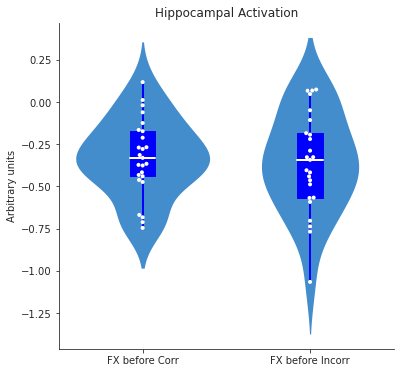

In [6]:
print('Descriptives')
for key in hp_plot:
    print('Mean {0}: '.format(key), np.mean(hp_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(hp_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [hp_plot['corr'], hp_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(hp_plot['corr'])[1] < 0.049 or stats.shapiro(hp_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(hp_plot['incorr'], hp_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(hp_plot['incorr'], hp_plot['corr'])[:])   
cohens_d = ((np.average(hp_plot['incorr'])-np.average(hp_plot['corr'])) 
            /(sqrt((np.std(hp_plot['incorr'],ddof=1))**2+np.std(hp_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_hpc.png", dpi=1000)
plt.show() 

# Medial PFC

Descriptives
Mean corr:  -0.7199784730666405
STD corr:  0.36273759802766536

Mean incorr:  -0.5493430568502111
STD incorr:  0.4446188965518973

Fixed Before Correct vs. Incorrect
Wilcoxon (102.0, 0.10731470584869385)
Cohen's d =  0.5827232080967012


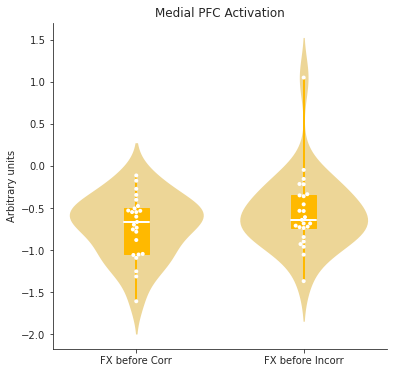

In [7]:
print('Descriptives')
for key in mpfc_plot:
    print('Mean {0}: '.format(key), np.mean(mpfc_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(mpfc_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [mpfc_plot['corr'], mpfc_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(mpfc_plot['corr'])[1] < 0.049 or stats.shapiro(mpfc_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(mpfc_plot['incorr'], mpfc_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(mpfc_plot['incorr'], mpfc_plot['corr'])[:])   
cohens_d = ((np.average(mpfc_plot['incorr'])-np.average(mpfc_plot['corr'])) 
            /(sqrt((np.std(mpfc_plot['incorr'],ddof=1))**2+np.std(mpfc_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_mpfc.png", dpi=1000)
plt.show() 

# Caudate

Descriptives
Mean corr:  -0.18890114259065488
STD corr:  0.27807697680406224

Mean incorr:  -0.24226526961271921
STD incorr:  0.27568257825968356

Fixed Before Correct vs. Incorrect
Wilcoxon (120.0, 0.2634761333465576)
Cohen's d =  -0.267057467631783


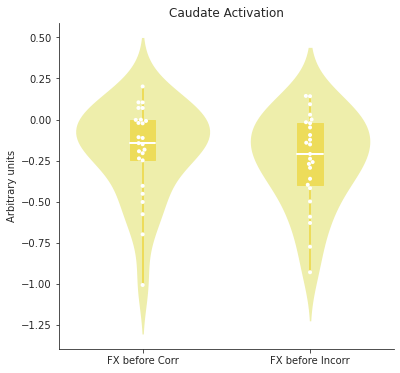

In [8]:
print('Descriptives')
for key in caud_plot:
    print('Mean {0}: '.format(key), np.mean(caud_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(caud_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [caud_plot['corr'], caud_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(caud_plot['corr'])[1] < 0.049 or stats.shapiro(caud_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(caud_plot['incorr'], caud_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(caud_plot['incorr'], caud_plot['corr'])[:])   
cohens_d = ((np.average(caud_plot['incorr'])-np.average(caud_plot['corr'])) 
            /(sqrt((np.std(caud_plot['incorr'],ddof=1))**2+np.std(caud_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_caud.png", dpi=1000)
plt.show() 

# Putamen

Descriptives
Mean corr:  0.18936686227014798
STD corr:  0.2739291159023524

Mean incorr:  0.12838114696840938
STD incorr:  0.26289511141647787

Fixed Before Correct vs. Incorrect
Wilcoxon (109.0, 0.15633821487426758)
Cohen's d =  -0.31476389025242224


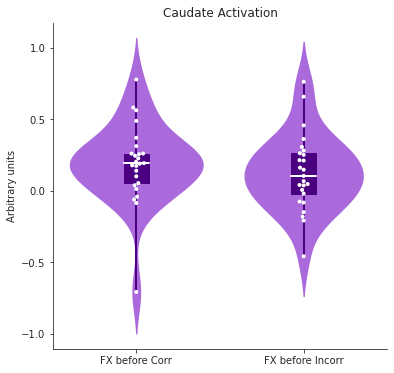

In [9]:
print('Descriptives')
for key in put_plot:
    print('Mean {0}: '.format(key), np.mean(put_plot['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(put_plot['{0}'.format(key)]))
    print('')
N = 2
conditions = ['FX before Corr', 'FX before Incorr']
allsubjs = [put_plot['corr'], put_plot['incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
print('Fixed Before Correct vs. Incorrect')
#use Shapiro test to determine normality of distributions
if stats.shapiro(put_plot['corr'])[1] < 0.049 or stats.shapiro(put_plot['incorr'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(put_plot['incorr'], put_plot['corr'])[:])
else: #normal distributions
    if stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(put_plot['incorr'], put_plot['corr'])[:])   
cohens_d = ((np.average(put_plot['incorr'])-np.average(put_plot['corr'])) 
            /(sqrt((np.std(put_plot['incorr'],ddof=1))**2+np.std(put_plot['corr'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/GLM1_put.png", dpi=1000)
plt.show() 

# Scatterplots

## - Compares avg preceding fixed activation with avg performance on conditional trials

In [10]:
all_prop_corr = []

for sub in subs:
    sub_dir = '/home/data/madlab/Mattfeld_vCAT/behav/{0}/'.format(sub)
    dir_files = sorted(glob(join(sub_dir, '{0}_simp_task*.csv'.format(sub)))) 
    
    run1 = pd.read_csv(dir_files[0]) #open each run
    run2 = pd.read_csv(dir_files[1])
    run3 = pd.read_csv(dir_files[2])
    run4 = pd.read_csv(dir_files[3])
 
    all_runs = [run1, run2, run3, run4] #concatenate all 4 runs 
    data_set = pd.concat(all_runs)
    trialtype = data_set['trialtype'].values #Numpy arrays for trial type and accuracy
    correct = data_set['acc'].values 
    
    trial_shift = trialtype[:-1] #removing last trial and shifting down 
    trial_shift = np.insert(trial_shift, 0, -1)
    correct_shift = correct[:-1]
    correct_shift = np.insert(correct_shift, 0, -1)
    #grab indices for trials matching specified criteria
    corr = sorted(np.where(((trialtype == 'cond') & (correct == 1)) & (trial_shift != 'BL'))[0])    
    incorr = sorted(np.where(((trialtype == 'cond') & (correct == 0)) & (trial_shift != 'BL'))[0])      
    all_prop_corr.append(len(corr)/float(len(corr)+len(incorr))) #append proportion of correct trials

all_data_df['prop_corr'] = all_prop_corr

### Average regional activation across all trial types

In [11]:
region = ['hp', 'mpfc', 'caud', 'put']
for r in region:
    all_data_df['{0}_fixed_cond'.format(r,l)] = (all_data_df['{0}_corr'.format(r)] 
                                                 + all_data_df['{0}_incorr'.format(r)])/2.

## Hippocampus

FIXED --> COND (0.24389102729127246, 0.2400470133070543)


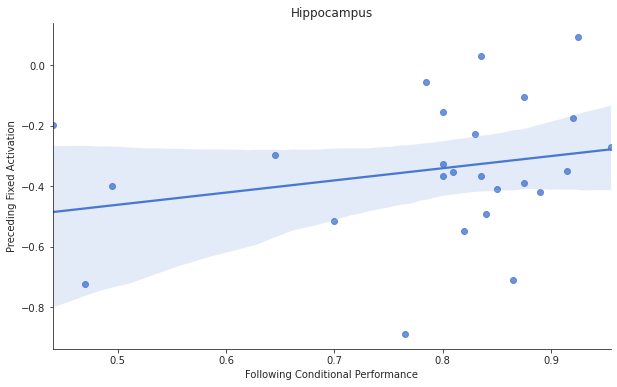

In [12]:
x = all_data_df['prop_corr']
y = all_data_df['hp_fixed_cond']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'hp_fixed_cond', data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Hippocampus')
plt.show()

## mPFC

FIXED --> COND (0.5525049467158019, 0.004183307265359319)


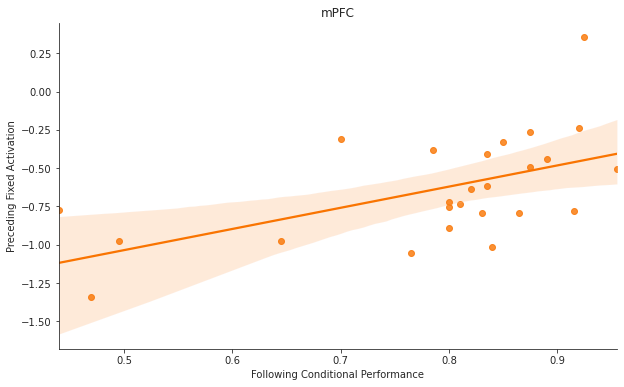

In [13]:
x = all_data_df['prop_corr']
y = all_data_df['mpfc_fixed_cond']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'mpfc_fixed_cond', color = '#f97401', data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('mPFC')
plt.show()

## Caudate

FIXED --> COND (-0.07641112072846576, 0.7165845423853671)


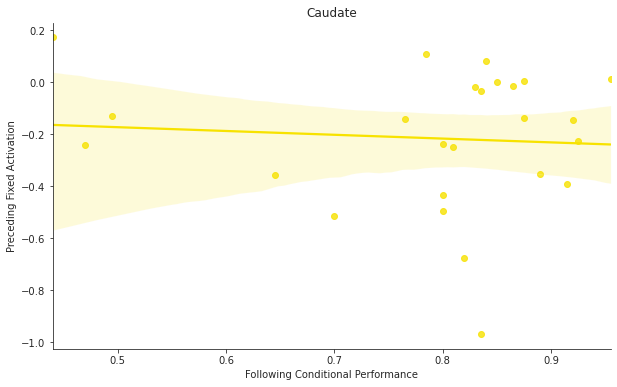

In [14]:
x = all_data_df['prop_corr']
y = all_data_df['caud_fixed_cond']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'caud_fixed_cond', color = "#f7e200", data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Caudate')
plt.show()

## Putamen

FIXED --> COND (0.05038588537692336, 0.8109635354653064)


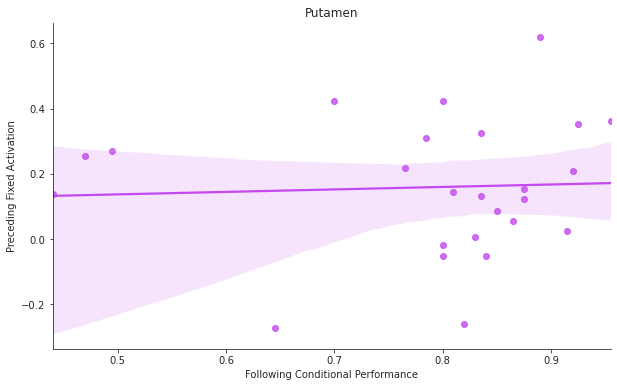

In [15]:
x = all_data_df['prop_corr']
y = all_data_df['put_fixed_cond']

print('FIXED --> COND', pearsonr(x,y))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'prop_corr', y = 'put_fixed_cond', color = "#c34aef", data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Preceding Fixed Activation')
ax.set_xlabel('Following Conditional Performance')
ax.set_title('Putamen')
plt.show()